In [153]:
import uuid
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

# add parent directory to sys path so we could access project modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

# get directory for saving results of plotting graphs
diagrams = os.path.join("..", "diagrams")

In [154]:
# Perfrom Extracting and some Transforming
# and convert columns from string list to list
df = pd.read_csv("../jobs.csv", converters={
    "contracts": literal_eval,
    "employment_type": literal_eval,
    "level_of_exp": literal_eval,
    "optional_skills": lambda v: literal_eval(v) if v else np.nan,
    "os": lambda v: literal_eval(v) if v else np.nan,
    "required_skills": literal_eval,
})

df.head()

,contracts,employment_type,level_of_exp,location,optional_skills,os,required_skills,ua_support
0,[contract of employment],[hybrid work],[mid],Kraków,NaN,NaN,"[Python, Java, C#, C++]",True
1,[B2B contract],"[home office work, hybrid work]","[mid, senior]",Warszawa,NaN,NaN,"[Python, Jenkins, SQL, API, Selenium]",False
2,[contract of employment],"[hybrid work, full office work]",[mid],Dąbrowa Górnicza,"[SQL, C++]",NaN,"[Python, C#]",False
3,[B2B contract],"[home office work, hybrid work]",[senior],Kraków,NaN,NaN,"[Python, Django]",False
4,[contract of employment],[home office work],[senior],Kraków,"[Google Cloud Platform, Django]",[macOS],"[Python, K8s, Docker, Ansible, Teamcity]",False


In [155]:
# Perfrom Transforming

# replace all empty list '[]' with nan
# df.contracts = df.contracts.apply(lambda v: v if v else np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   contracts        495 non-null    object
 1   employment_type  495 non-null    object
 2   level_of_exp     495 non-null    object
 3   location         495 non-null    object
 4   optional_skills  326 non-null    object
 5   os               107 non-null    object
 6   required_skills  495 non-null    object
 7   ua_support       495 non-null    bool  
dtypes: bool(1), object(7)
memory usage: 27.7+ KB


In [156]:
# Make each values in employment_type, os, level_of_exp, contracts column.
# This approach is aligned with database normalization principles
# which aim to reduce redundancy and improve data integrity.

# where 1 indicates True and 0 False
contracts_explode = df.contracts.explode()
contracts = pd.crosstab(contracts_explode.index, contracts_explode)

level_of_exp_explode = df.level_of_exp.explode()
level_of_exp = pd.crosstab(level_of_exp_explode.index, level_of_exp_explode)

employment_types_explode = df.employment_type.explode()
employment_types = pd.crosstab(employment_types_explode.index, employment_types_explode)

o_s = df.os.explode()
o_s = pd.crosstab(o_s.index, o_s)

df = df.drop(["contracts", "employment_type", "level_of_exp", "os"], axis=1)
df.head()

,location,optional_skills,required_skills,ua_support
0,Kraków,NaN,"[Python, Java, C#, C++]",True
1,Warszawa,NaN,"[Python, Jenkins, SQL, API, Selenium]",False
2,Dąbrowa Górnicza,"[SQL, C++]","[Python, C#]",False
3,Kraków,NaN,"[Python, Django]",False
4,Kraków,"[Google Cloud Platform, Django]","[Python, K8s, Docker, Ansible, Teamcity]",False


In [157]:
employment_types_explode.head()

0         hybrid work
1    home office work
1         hybrid work
2         hybrid work
2    full office work
Name: employment_type, dtype: object

In [158]:
level_of_exp.head()

level_of_exp,assistant,expert,junior,lead,manager,mid,senior,trainee
row_0,,,,,,,,
0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0
2,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0


In [159]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Define a function to remove duplicates and update counts
def removing_duplicates(tool_counts) -> dict:
    """
    Removing duplicates, exp 'AI', 'AI services' - is same,
    'AI' should stay, and 'AI services' count value should be
    added to 'AI' count
    """
    unq_words = {}
    duplicates = set()

    # Sort tool_counts by length of keys (tool names)
    tool_counts_sorted = tool_counts.sort_index(key=lambda v: v.str.len())

    for tool, count in tool_counts_sorted.items():
        if tool not in duplicates:
            matches = process.extractBests(
                tool, 
                tool_counts_sorted.index, 
                scorer=lambda str1, str2: fuzz.ratio(str1.lower(), str2.lower()),
                score_cutoff=70
            )
            
            # Filter out matches that are similar to the current tool
            filtered_matches = {match for match, score in matches if match != tool and (
                match.lower().startswith(tool.lower()) or score >= 85
            )}
            
            # Add count of similar tools to the current tool
            unq_words[tool] = count + sum(tool_counts[match] for match in filtered_matches)
            duplicates |= filtered_matches

    return unq_words

In [160]:
# Make all required and optional skills into one Series
required_skills = pd.Series(df.required_skills.sum())
optional_skills = pd.Series(df.optional_skills.dropna().sum())

# Count the occurrences of each skill
required_skills_counts = required_skills.value_counts()
optional_skills_counts = optional_skills.value_counts()

In [161]:
# Remove duplicates, because we have scraped data not only 
# from setted up labels on website but also we have processed text requirements
# and update counts for optional and required skills
required_skills_dict = removing_duplicates(required_skills_counts)
optional_skills_dict = removing_duplicates(optional_skills_counts)

# Create DataFrames from dictionary
required_skills_df = pd.DataFrame(
    {
        "skills": list(required_skills_dict.keys()),
        "count": list(required_skills_dict.values())
    }
)
optional_skills_df = pd.DataFrame(
    {
        "skills": list(optional_skills_dict.keys()),
        "count": list(optional_skills_dict.values())
    }
)

# Sort DataFrame by count in descending order
required_skills_df = required_skills_df.sort_values(by="count", ascending=False)
optional_skills_df = optional_skills_df.sort_values(by="count", ascending=False)

# save required_skills_counts and optional_skills_counts
# required_skills_df.to_csv("../required_skills.csv", index=False)
# optional_skills_df.to_csv("../optional_skills.csv", index=False)

optional_skills_df.head(), required_skills_df.head()

(      skills  count
 98    Python     78
 118  Windows     76
 76     Linux     51
 20       AWS     26
 94    Docker     20,
      skills  count
 159  Python    421
 45      SQL    170
 0         C    106
 44      AWS     78
 7       GIT     71)

In [162]:
optional_skills_df.info(), required_skills_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 98 to 228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   skills  229 non-null    object
 1   count   229 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 380 entries, 159 to 379
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   skills  380 non-null    object
 1   count   380 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.9+ KB


(None, None)

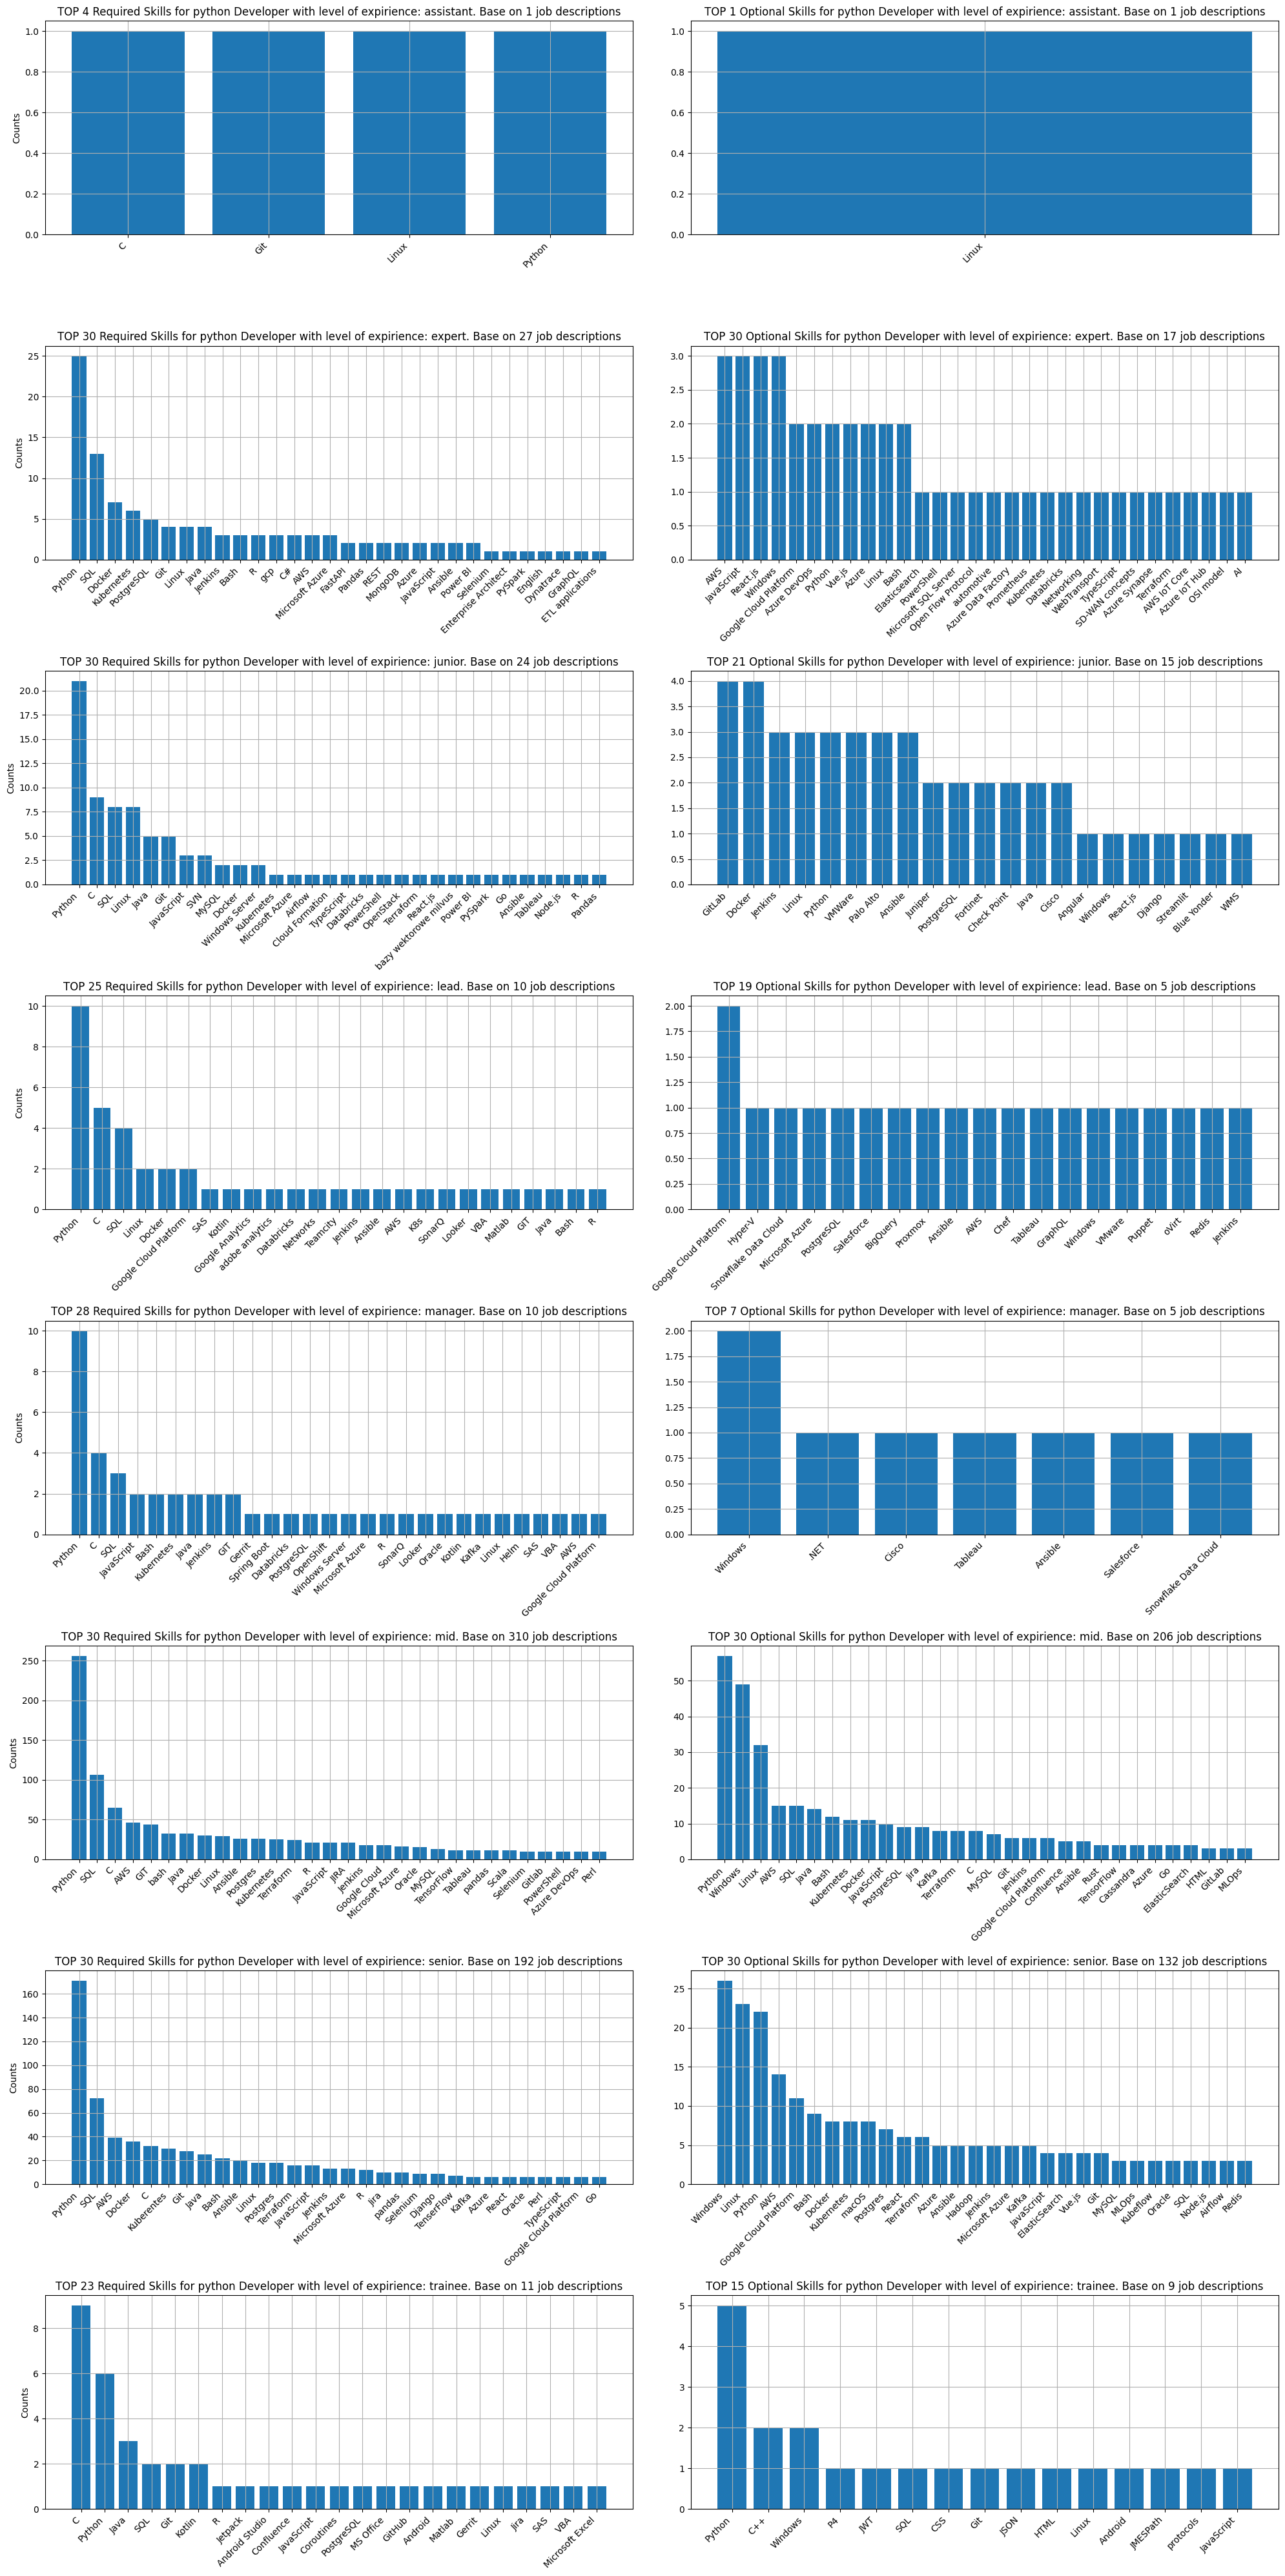

In [163]:
# show required and optional skills base on level of expirience

df_exp = df.merge(level_of_exp, right_index=True, left_index=True)

fig, axes = plt.subplots(len(level_of_exp.columns), 2, figsize=(20, len(level_of_exp.columns) * 5))

for i, exp_level in enumerate(level_of_exp.columns):

    exp_level_df = df_exp[df_exp[exp_level] == 1]
    
    exp_required_skills = pd.Series(exp_level_df["required_skills"].sum())
    exp_optional_skills = pd.Series(exp_level_df["optional_skills"].dropna().sum())
    
    exp_required_skills_count = exp_required_skills.value_counts()
    exp_optional_skills_count = exp_optional_skills.value_counts()

    exp_required_skills_dict = removing_duplicates(exp_required_skills_count)
    exp_optional_skills_dict = removing_duplicates(exp_optional_skills_count)

    exp_required_skills_df = pd.DataFrame(
        {
            "skills": list(exp_required_skills_dict.keys()),
            "count": list(exp_required_skills_dict.values())
        }
    )
    exp_optional_skills_df = pd.DataFrame(
        {
            "skills": list(exp_optional_skills_dict.keys()),
            "count": list(exp_optional_skills_dict.values())
        }
    )
    exp_required_skills_df  = exp_required_skills_df.sort_values(by="count", ascending=False)
    exp_optional_skills_df  = exp_optional_skills_df.sort_values(by="count", ascending=False)

    exp_requried_top_skills = exp_required_skills_df.iloc[:30]
    exp_optional_top_skills = exp_optional_skills_df.iloc[:30]
    
    # get required and optional diagram
    re_axe = axes[i, 0]
    op_axe = axes[i, 1]

    # show top required skills base on exp_level
    re_axe.bar(exp_requried_top_skills["skills"], exp_requried_top_skills["count"])
    
    re_axe.set_title((
        f"TOP {len(exp_requried_top_skills)} Required Skills for {POSITION} Developer"
        f" with level of expirience: {exp_level}. Base on {exp_level_df.shape[0]} job descriptions"
    ))
    re_axe.set_xticks(range(len(exp_requried_top_skills["skills"])))
    re_axe.set_xticklabels(exp_requried_top_skills["skills"], rotation=45, ha="right")
    re_axe.set_ylabel("Counts")
    re_axe.grid(True)

    # show top optional skills base on exp_level
    op_axe.bar(exp_optional_top_skills["skills"], exp_optional_top_skills["count"])

    op_axe.set_title((
        f"TOP {len(exp_optional_top_skills)} Optional Skills for {POSITION} Developer"
        f" with level of expirience: {exp_level}. Base on {len(exp_level_df['optional_skills'].dropna())} job descriptions"
    ))
    op_axe.set_xticks(range(len(exp_optional_top_skills["skills"])))
    op_axe.set_xticklabels(exp_optional_top_skills["skills"], rotation=45, ha="right")
    op_axe.grid(True)

plt.tight_layout()
plt.show()

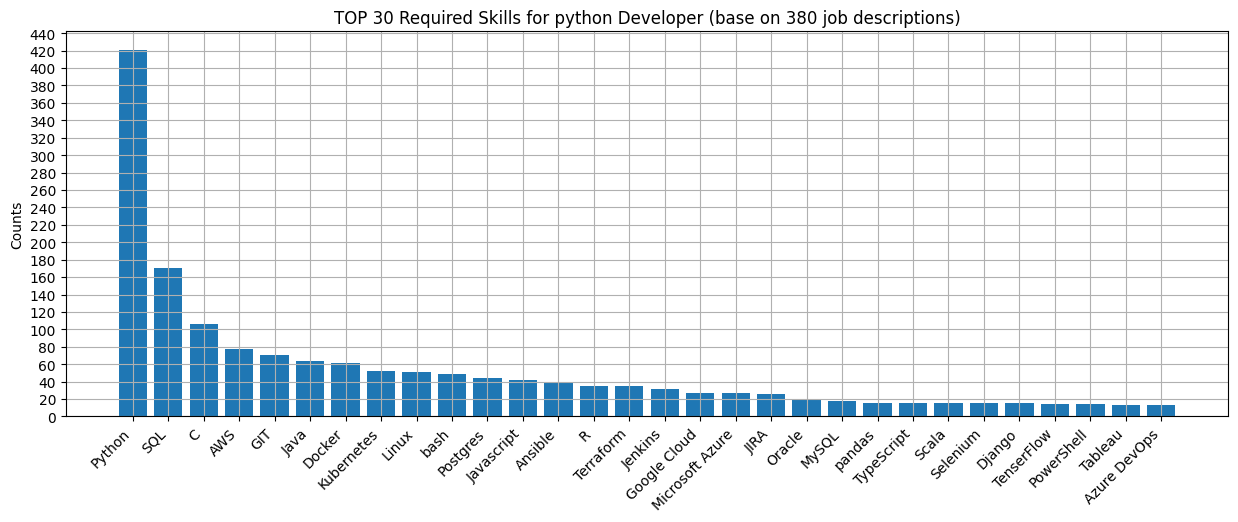

In [164]:
from config import POSITION

# get top 30 required skills
top_skills = required_skills_df.iloc[:30, :]

plt.figure(figsize=(15, 5))
plt.bar(top_skills.skills, top_skills["count"])

plt.title(f"TOP {top_skills.shape[0]} Required Skills for {POSITION} Developer (base on {required_skills_df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, top_skills["count"].max() + 20, 20))
plt.grid(True)

# save diagram
# required_skills_diagram = os.path.join(diagrams, "required_skills")
# plt.savefig(os.path.join(required_skills_diagram, f"required_skills_{uuid.uuid4()}.jpg"))

plt.show()

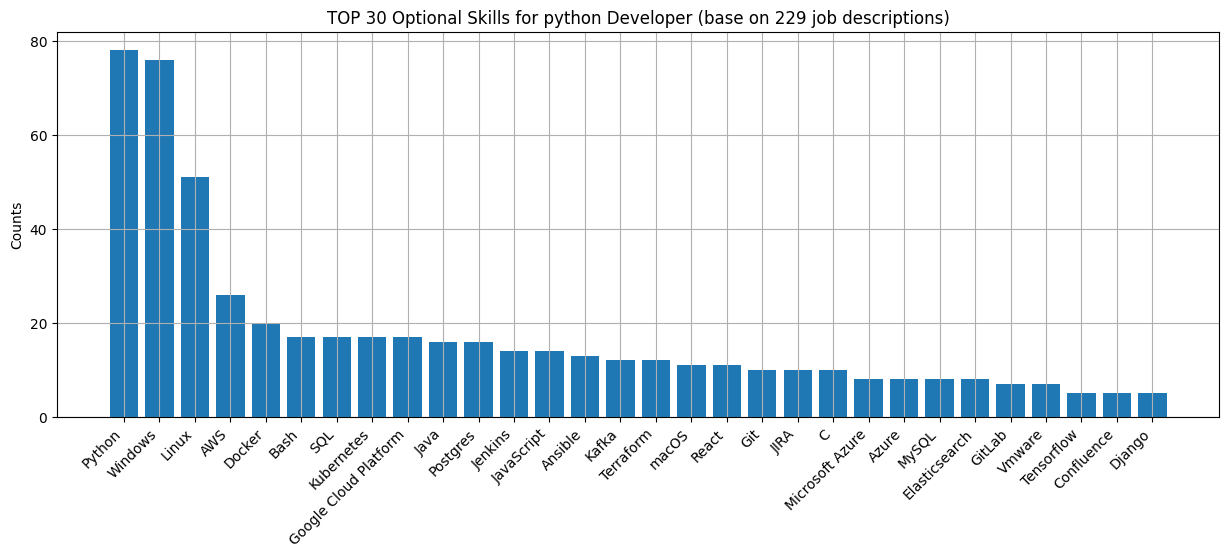

In [13]:
from config import POSITION

# get top 30 optional skills
top_skills = optional_skills_df.iloc[:30, :]

plt.figure(figsize=(15, 5))
plt.bar(top_skills.skills, top_skills["count"])

plt.title(f"TOP {top_skills.shape[0]} Optional Skills for {POSITION} Developer (base on {optional_skills_df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, top_skills["count"].max() + 20, 20))
plt.grid(True)

# save diagram
# optional_skills_diagram = os.path.join(diagrams, "optional_skills")
# plt.savefig(os.path.join(optional_skills_diagram, f"optional_skills_{uuid.uuid4()}.jpg"))

plt.show()

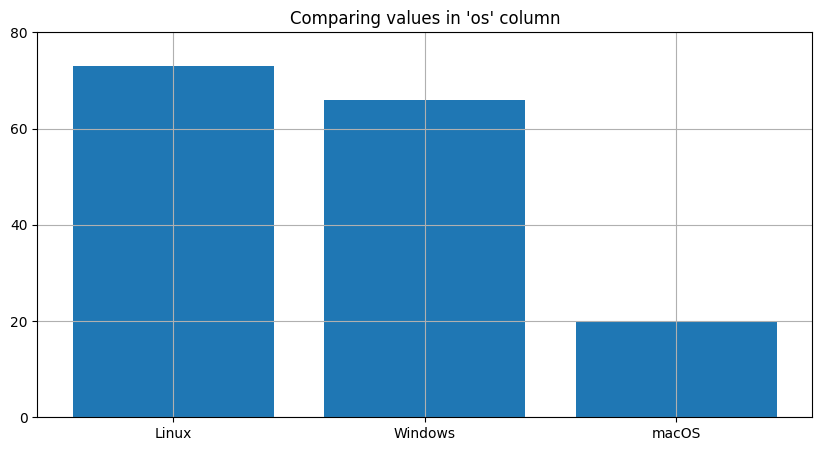

In [14]:
# show comparisons between values in data frame 'o_s'
o_s_sum = o_s.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(o_s_sum.index, o_s_sum)
plt.title("Comparing values in 'os' column")

plt.yticks(range(0, o_s_sum.max() + 10, 20))
plt.grid(True)

plt.show()

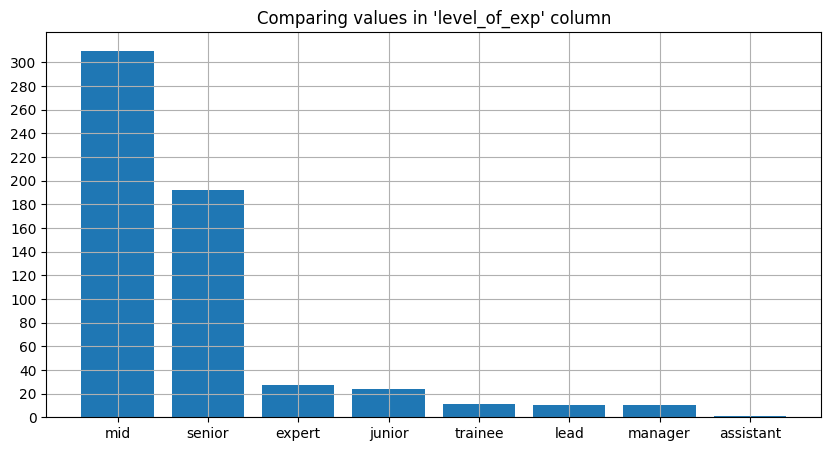

In [17]:
# show comparisons between values in data frame 'level_of_exp'
level_of_exp_sum = level_of_exp.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(level_of_exp_sum.index, level_of_exp_sum)
plt.title("Comparing values in 'level_of_exp' column")

plt.yticks(range(0, level_of_exp_sum.max() + 10, 20))
plt.grid(True)

plt.show()

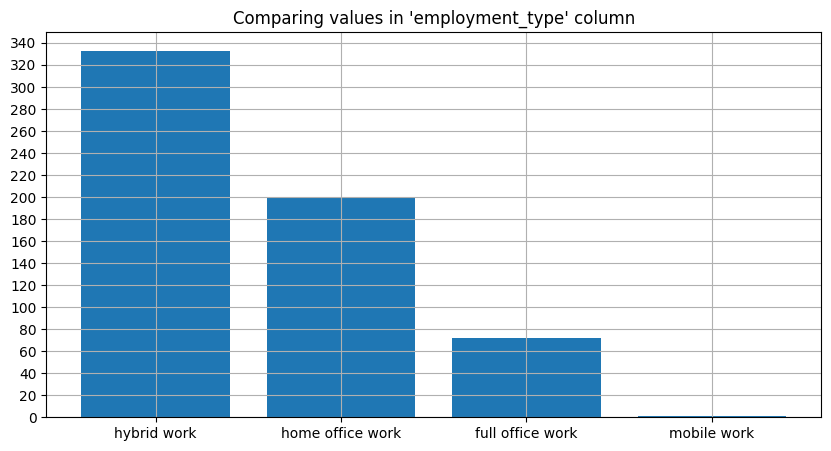

In [18]:
# show comparisons between values in data frame 'employment_type'
employment_type_sum = employment_types.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(employment_type_sum.index, employment_type_sum)
plt.title("Comparing values in 'employment_type' column")

plt.yticks(range(0, employment_type_sum.max() + 10, 20))
plt.grid(True)

plt.show()

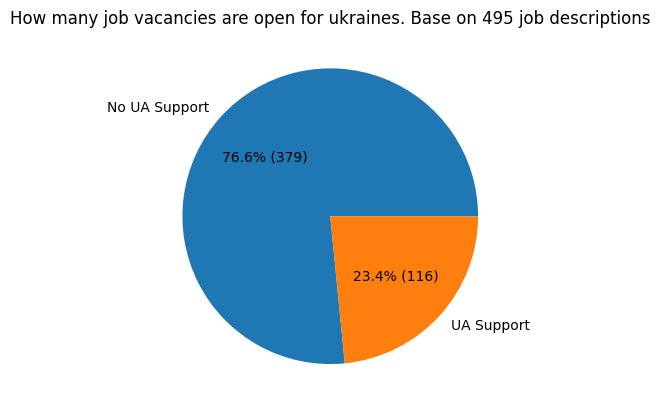

In [176]:
# show comparisons between values in data frame 'contracts'
ua_support = df["ua_support"].value_counts().sort_values(ascending=False)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f"{pct:.1f}% ({absolute:d})"

plt.pie(
    ua_support,
    autopct=lambda v: func(v, ua_support),
    labels=("No UA Support", "UA Support"),
    textprops={"verticalalignment": "center"},
                                  )
plt.title(f"How many job vacancies are open for ukraines. Base on {df.shape[0]} job descriptions")
plt.show()

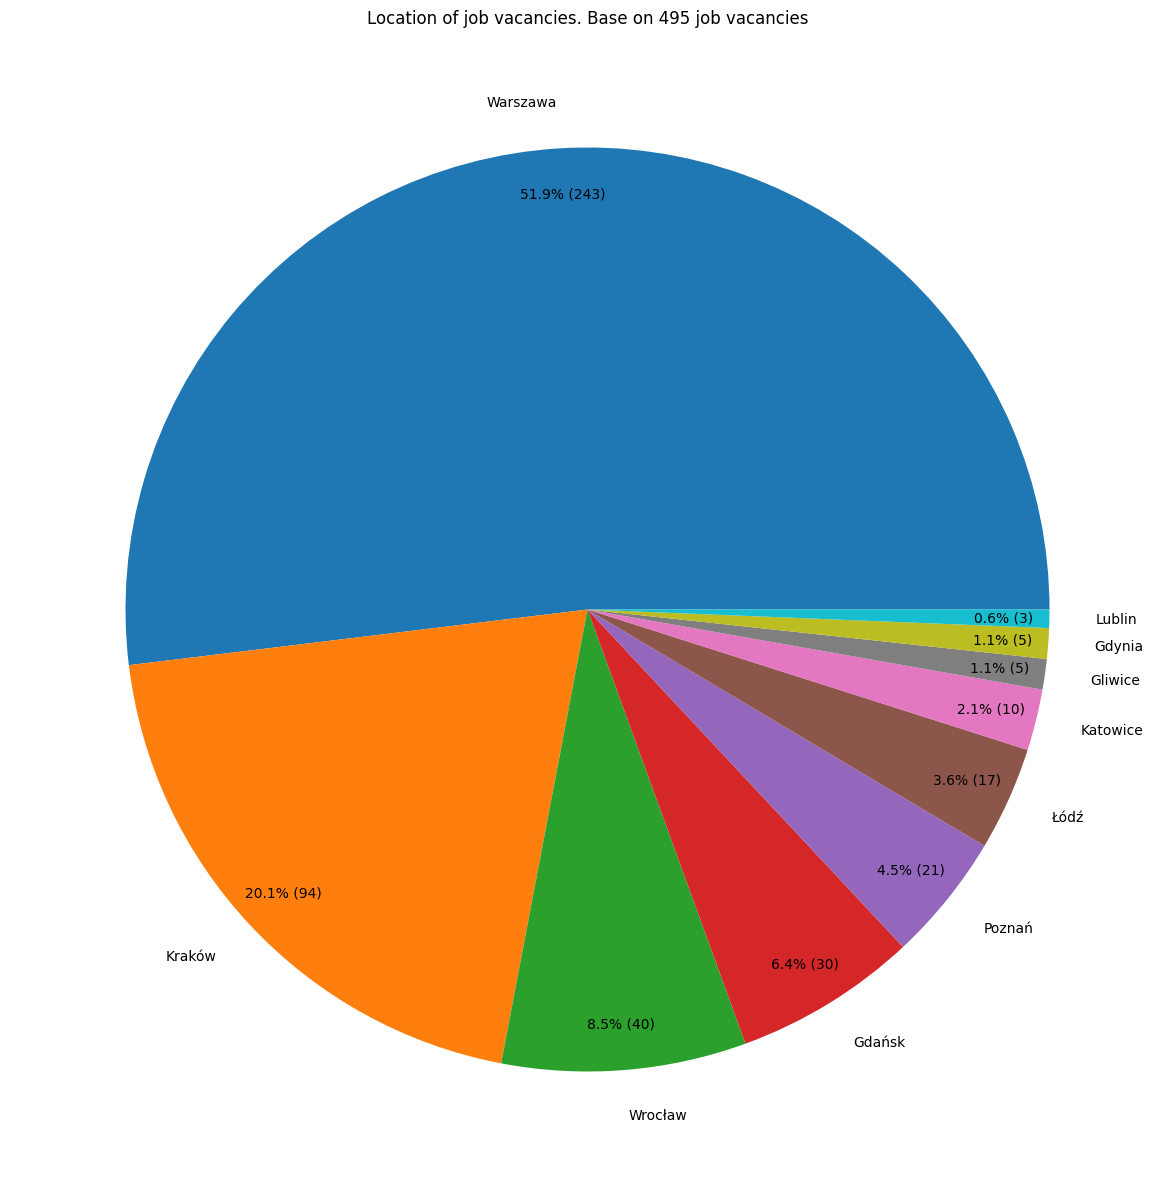

In [50]:
# get top 20 locations to work in Poland
locations_values = df.location.value_counts().sort_values(ascending=False)
top_locations = locations_values.iloc[:10]

fig, ax = plt.subplots(figsize=(15, 15))
explode = [0.05] * len(top_locations)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f"{pct:.1f}% ({absolute:d})"

wedges, texts, autotexts = ax.pie(
    top_locations,
    autopct=lambda v: func(v, top_locations),
    labels=top_locations.index,
    # explode=explode,
    textprops={"verticalalignment": "center"},
    pctdistance=0.9
                                  )
ax.set_title(f"Location of job vacancies. Base on {df.shape[0]} job vacancies")
plt.show()

# save diagram
# optional_skills_diagram = os.path.join(diagrams, "optional_skills")
# plt.savefig(os.path.join(optional_skills_diagram, f"optional_skills_{uuid.uuid4()}.jpg"))



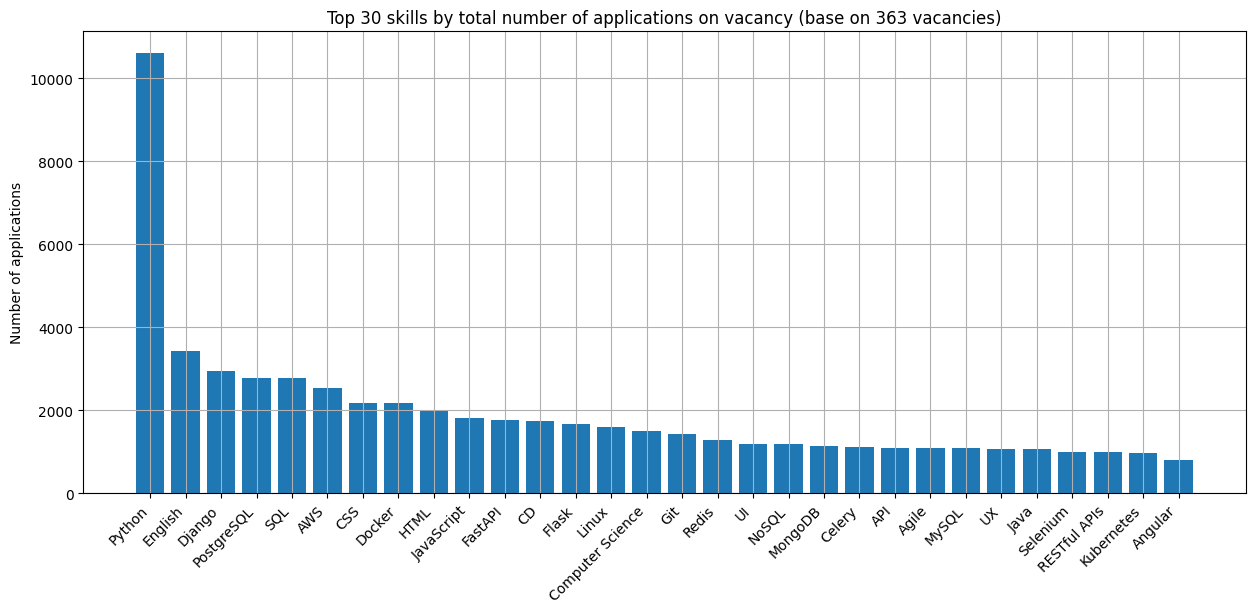

In [36]:
# Show top skills by each skill total number of applications on vacancy
skills = df.explode("tools")

skill_application = skills.groupby("tools")["num_applications"].sum().reset_index()
skills = skill_application.sort_values(by="num_applications", ascending=False)
top_skills = skills.iloc[:30, :]

plt.figure(figsize=(15, 6))
plt.bar(top_skills["tools"], top_skills["num_applications"])

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of applications")
plt.title(f"Top {top_skills.shape[0]} skills by total number of applications on vacancy (base on {df.shape[0]} vacancies)")
plt.grid(True)

by_applications = os.path.join(diagrams, "by_applications")
plt.savefig(os.path.join(by_applications, f"skills_{uuid.uuid4()}.jpg")

plt.show()

In [11]:
# loading
df.to_csv("../jobs.csv")